In [45]:
import random
from typing_extensions import TypedDict, Annotated, List
import operator
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, AnyMessage
from langchain_openai import ChatOpenAI
from IPython.display import Image, display

In [46]:
llm = ChatOpenAI(
  model="gpt-4o-mini",
  temperature=0.0,
  base_url="https://openai.vocareum.com/v1"
)

Data Processing (Sequential)

In [47]:
class State(TypedDict):
  input: int
  output: int


In [48]:
def node_a(state: State)->State:
  input_value = state['input']
  offset = random.randint(1,10)
  output = input_value + offset
  print(
    f"NODE A: \n"
    f"->input:{input_value}\n"
    f"->offset:{offset}\n"
    f"->output:{output}"
  )
  
  return {"output": output}

In [49]:
def node_b(state: State):
  input_value = state['output']
  offset = random.randint(1,10)
  output = input_value + offset
  print(
    f"NODE B: \n"
    f"->input:{input_value}\n"
    f"->offset:{offset}\n"
    f"->output:{output}"
  )
  
  return {"output": output}

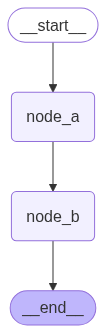

In [50]:
workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_a", END)
graph = workflow.compile()
display(
  Image(
    graph.get_graph().draw_mermaid_png()
  )
)

In [51]:
graph.invoke(
  input = {
    "input": 1
  }
)

NODE A: 
->input:1
->offset:3
->output:4
NODE B: 
->input:4
->offset:8
->output:12


{'input': 1, 'output': 12}

Data Processing (Parallel)

In [52]:
class State(TypedDict):
  input: int
  output: int


In [53]:
def node_a(state: State)->State:
  input_value = state['input']
  offset = random.randint(1,10)
  output = input_value + offset
  print(
    f"NODE A: \n"
    f"->input:{input_value}\n"
    f"->offset:{offset}\n"
    f"->output:{output}"
  )
  
  return {"output": output}


def node_b(state: State):
  input_value = state['input'] # Coming from input
  offset = random.randint(1,10)
  output = input_value + offset
  print(
    f"NODE B: \n"
    f"->input:{input_value}\n"
    f"->offset:{offset}\n"
    f"->output:{output}"
  )
  
  return {"output": output}

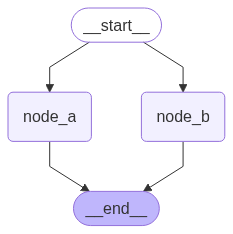

In [54]:
workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge(START, "node_b")
workflow.add_edge("node_a", END)
workflow.add_edge("node_b", END)
graph = workflow.compile()
display(
  Image(
    graph.get_graph().draw_mermaid_png()
  )
)

In [55]:
# graph.invoke(
#   input = {
#     "input": 1
#   }
# )

Data Processing with a Reducer

In [56]:
help(operator.add)

Help on built-in function add in module _operator:

add(a, b, /)
    Same as a + b.



In [57]:
operator.add([1,2,3], [4,5,6])

[1, 2, 3, 4, 5, 6]

In [58]:
class State(TypedDict):
  input: int
  output: Annotated[List[int], operator.add]


In [59]:
def node_a(state: State):
  input_value = state['input']
  offset = random.randint(1,10)
  output = input_value + offset
  print(
    f"NODE A: \n"
    f"->input:{input_value}\n"
    f"->offset:{offset}\n"
    f"->output:{output}"
  )
  
  return {"output": [output]} # now it's a List of ints


def node_b(state: State):
  input_value = state['input'] # Coming from input
  offset = random.randint(1,10)
  output = input_value + offset
  print(
    f"NODE B: \n"
    f"->input:{input_value}\n"
    f"->offset:{offset}\n"
    f"->output:{output}"
  )
  
  return {"output": [output]}

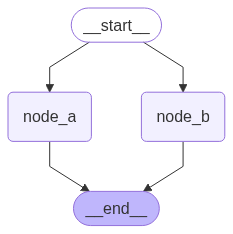

In [60]:
workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge(START, "node_b")
workflow.add_edge("node_a", END)
workflow.add_edge("node_b", END)
graph = workflow.compile()
display(
  Image(
    graph.get_graph().draw_mermaid_png()
  )
)

In [61]:
graph.invoke(
  input = {
    "input": 1
  }
)

NODE A: 
->input:1
->offset:2
->output:3
NODE B: 
->input:1
->offset:7
->output:8


{'input': 1, 'output': [3, 8]}

Call LLMs with Custom State and Langgraph operator

In [62]:
operator.add(
  [
    SystemMessage("You're a helpful assistant"),
    HumanMessage("Hi!")
  ],
  [
    AIMessage("Hello! How Can I assist you today?")
  ]
)

[SystemMessage(content="You're a helpful assistant", additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Hi!', additional_kwargs={}, response_metadata={}),
 AIMessage(content='Hello! How Can I assist you today?', additional_kwargs={}, response_metadata={})]

In [63]:
# operator.add(
#   [
#     SystemMessage("You're a helpful assistant"),
#     HumanMessage("Hi!")
#   ],
#   AIMessage("Hello! How Can I assist you today?")
# )

In [64]:
help(add_messages)

Help on function _add_messages in module langgraph.graph.message:

_add_messages(left: Union[list[Union[langchain_core.messages.base.BaseMessage, list[str], tuple[str, str], str, dict[str, Any]]], langchain_core.messages.base.BaseMessage, list[str], tuple[str, str], str, dict[str, Any], NoneType] = None, right: Union[list[Union[langchain_core.messages.base.BaseMessage, list[str], tuple[str, str], str, dict[str, Any]]], langchain_core.messages.base.BaseMessage, list[str], tuple[str, str], str, dict[str, Any], NoneType] = None, **kwargs: Any) -> Union[list[Union[langchain_core.messages.base.BaseMessage, list[str], tuple[str, str], str, dict[str, Any]]], langchain_core.messages.base.BaseMessage, list[str], tuple[str, str], str, dict[str, Any], Callable[[Union[list[Union[langchain_core.messages.base.BaseMessage, list[str], tuple[str, str], str, dict[str, Any]]], langchain_core.messages.base.BaseMessage, list[str], tuple[str, str], str, dict[str, Any]], Union[list[Union[langchain_core.messa

In [65]:
add_messages(
  left=[
    SystemMessage("You're a helpful assistant"),
    HumanMessage("Hi!")
  ],
  right = AIMessage("Hello! How Can I assist you today?")
)

[SystemMessage(content="You're a helpful assistant", additional_kwargs={}, response_metadata={}, id='51ea12c0-833c-48ea-8109-db5f0bc52617'),
 HumanMessage(content='Hi!', additional_kwargs={}, response_metadata={}, id='fa461737-a39e-4c41-8abc-45552850daee'),
 AIMessage(content='Hello! How Can I assist you today?', additional_kwargs={}, response_metadata={}, id='44806019-76ae-4cab-8ce1-dbeb8e646432')]

In [66]:
class State(TypedDict):
  messages: Annotated[List[AnyMessage], add_messages]


In [67]:
def model(state: State):
  messages = state["messages"]
  response = llm.invoke(messages)
  return {"messages": response}


In [68]:
workflow = StateGraph(State)
workflow.add_node("model", model)
workflow.add_edge(START, "model")
workflow.add_edge("model", END)
graph = workflow.compile()

In [69]:
result = graph.invoke(
  input = {
    "messages": [HumanMessage("What's the the name of Ash's first pokemon?")]
  }
)

In [70]:
for msg in result['messages']:
  msg.pretty_print()

================================ Human Message =================================

What's the the name of Ash's first pokemon?
================================== Ai Message ==================================

Ash's first Pokémon is Pikachu. He received Pikachu from Professor Oak at the beginning of his journey in the Pokémon anime series.


Call LLMs with Langgraph MessagesState

In [71]:
def model(state: MessagesState):
  messages = state["messages"]
  response = llm.invoke(messages)
  return {"messages": response}


In [72]:
workflow = StateGraph(MessagesState)
workflow.add_node("model", model)
workflow.add_edge(START, "model")
workflow.add_edge("model", END)
graph = workflow.compile()

In [73]:
result = graph.invoke(
  input = {
    "messages": [HumanMessage("What's the the name of Ash's first pokemon?")]
  }
)

In [74]:
for msg in result['messages']:
  msg.pretty_print()

================================ Human Message =================================

What's the the name of Ash's first pokemon?
================================== Ai Message ==================================

Ash's first Pokémon is Pikachu. He received Pikachu from Professor Oak at the beginning of his journey in the Pokémon anime series.
